In [1]:
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.plots.stan
import lib.utils.ez_priors
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D
import retro_prepare_data
import matplotlib.colors

In [2]:
patient_id = 'id039_mra'
data_dir = f'datasets/retro/{patient_id}'
results_dir = f'results/tmp/{patient_id}'
szr_name = 'MR_C4P_170124b-cex_0028'
# szr_name = 'BJcrise1le161128B-BEX_0002'
meta_data_fname = f'{szr_name}.json'
raw_seeg_fname = f'{szr_name}.raw.fif'
fname_suffix = f'{szr_name}'
# if os.path.isdir(results_dir):
#     os.rmdir(results_dir)
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)
os.makedirs(f'{results_dir}/Rfiles', exist_ok=True)

In [ ]:
hpf = 10
lpf = 0.05
data = retro_prepare_data.prepare_data(data_dir, meta_data_fname, raw_seeg_fname, hpf, lpf)
fname_suffix += f'_hpf{hpf}_lpf{lpf}'

Isotrak not found
EZ based on EI: ['Right-Subcallosal-area', 'Right-Collateral-sulcus', 'Right-Parahippocampal-cortex', 'Right-Rhinal-cortex', 'Right-Orbito-frontal-cortex', 'Right-Temporal-pole', 'Right-T1-planum-polare', 'Right-Gyrus-rectus', 'Right-Hippocampus-anterior', 'Right-Amygdala'] [98, 131, 133, 134, 82, 115, 116, 83, 153, 155]
EZ clinical hypothesis: [ 82  83  86 108 113 115 130 131 133 134 153 155]
('TP2', 0)


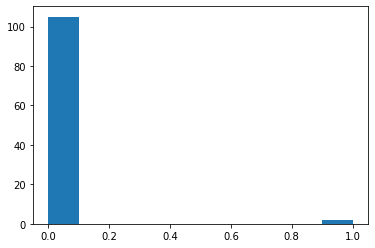

In [15]:
import importlib
importlib.reload(lib.utils.ez_priors)
ep_idx, Nd, N0, ER = lib.utils.ez_priors.comp_epindx(
    data_dir,
    raw_seeg_fname,
    meta_data_fname,
    bias=20,
    thrshld=300,
    tau=1,
    wndw_len=1024,
    wndw_ovrlp=512,
    ei_wndw_len=5,
    plots = True)
ep_idx_keys, ep_idx_vals = zip(*ep_idx.items())
ep_idx_vals = np.array(ep_idx_vals)
cntcts_file = os.path.join(data_dir, 'elec', 'seeg.xyz')
cntrs_zipfile = os.path.join(data_dir,'tvb', 'connectivity.vep.zip')
ez_names, ez_idcs = lib.utils.ez_priors.get_ez_from_epindx(ep_idx, 0.5, cntcts_file, cntrs_zipfile, dist_prcntl=5.0)
print("EZ based on EI:", ez_names, ez_idcs)
ez_hyp = np.where(np.loadtxt(f'{data_dir}/tvb/ez_hypothesis.vep.txt') == 1)[0]
print("EZ clinical hypothesis:", ez_hyp)
print(N0)
np.save(os.path.join(results_dir, "ei_ez_idcs.npy"), np.array(ez_idcs))
plt.figure()
plt.hist(ep_idx_vals);

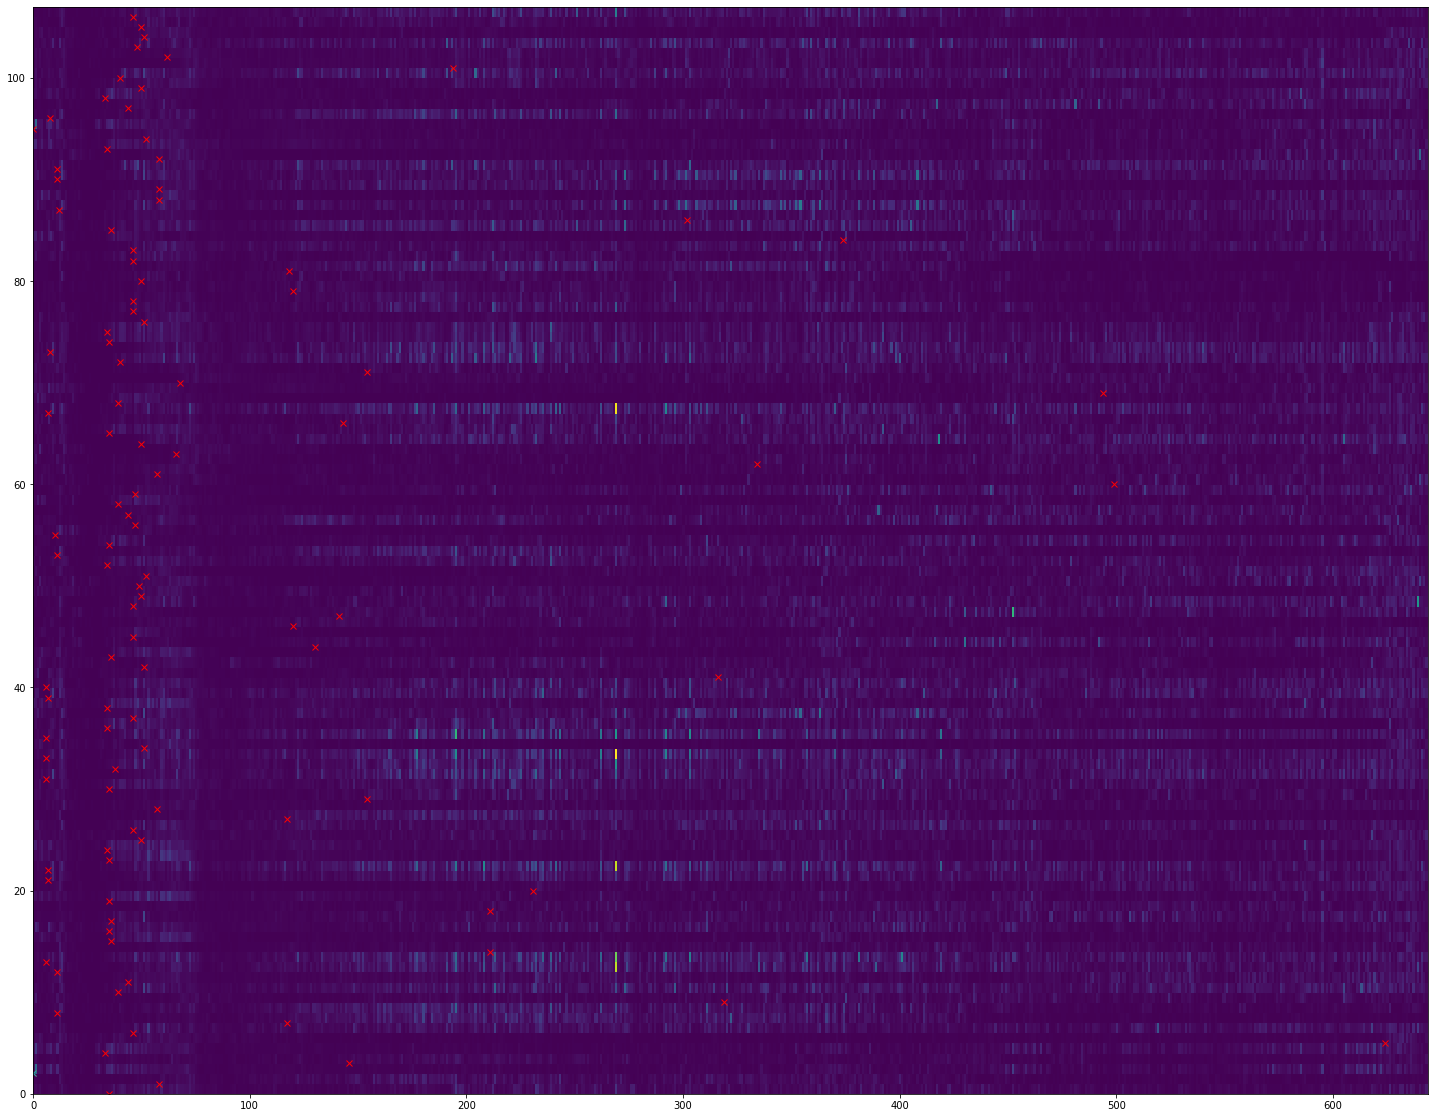

In [36]:
# x = np.arange(-5, 5, 0.1)
# y = np.arange(-5, 3, 0.1)
# xx, yy = np.meshgrid(x, y, sparse=True)
# z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)
# h = plt.pcolormesh(x,y,z)j

# # plt.plot([-2, -2+], 1, 'rx')
# plt.show()
# # x, y = np.meshgrid()

# plt.figure(figsize=(15,10))
# ER_mat = np.zeros(len(ER.keys()), np.zeros(ER.values()))
k, v = zip(*ER.items())
ER_mat = np.array(v)
# for i,(ch_name,ts) in enumerate(ER.items()):
plt.figure(figsize=(25,20))
plt.pcolormesh(ER_mat)
plt.plot([Nd[ch_name] for ch_name in k], np.r_[0:len(k)], 'rx')
plt.plot(N0[1], k.index(N0[0]),  'cx')


In [33]:
k[k.index(N0[0])], N0

('TP2', ('TP2', 0))

In [ ]:
ds_freq = int(data['slp'].shape[0]/150)
data['slp'] = data['slp'][0:-1:ds_freq]
data['snsr_pwr'] = (data['slp']**2).mean(axis=0)
data['ns'], data['nn'] = data['gain'].shape
data['nt'] = data['slp'].shape[0]
data['x0_mu'] = -3.0*np.ones(data['nn'])
data['x0_mu'][ez_idcs] = -1.5

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(data['SC'],norm=matplotlib.colors.LogNorm(vmin=1e-6, vmax=data['SC'].max()));
plt.colorbar(fraction=0.046,pad=0.04);
plt.title('Normalized SC (log scale)',fontsize=12, fontweight='bold')

plt.subplot(122)
plt.imshow(data['gain'],norm=matplotlib.colors.LogNorm(vmin=data['gain'].min(), vmax=data['gain'].max()));
plt.colorbar(fraction=0.046,pad=0.04);
plt.xlabel('Region#', fontsize=12)
plt.ylabel('Channel#', fontsize=12)
plt.title('Gain Matrix (log scale)',fontsize=12, fontweight='bold')
plt.savefig(f'{results_dir}/figures/network.png')

plt.figure(figsize=(25,13))
plt.subplot(211)
plt.plot(data['slp'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('SLP', fontsize=12)

plt.subplot(212)
plt.bar(np.r_[1:data['ns']+1],data['snsr_pwr'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.title('SEEG channel power', fontweight='bold')
plt.savefig(f'{results_dir}/figures/fitting_target_{fname_suffix}.png')
# plt.tight_layout()


In [ ]:
plt.figure(figsize=(25,5))
plt.bar(np.r_[1:data['nn']+1],data['x0_mu'], color='black', alpha=0.3)
plt.xticks(np.r_[1:data['nn']+1:2], fontsize=8);
plt.xlabel('ROI#')
plt.ylabel(r'$x_0$', fontsize=10)
plt.savefig(f'{results_dir}/figures/ez_hyp.png')

In [ ]:
stan_fname = 'szr_prpgtn'


x0 = data['x0_mu']
amplitude = 1.0 
offset = 0
K = 1.0
tau0 = 20
eps_slp = 1.0
eps_snsr_pwr = 1.0
eps_x0 = np.ones(data['nn'])
x_init = -2.0*np.ones(data['nn'])
z_init = 3.5*np.ones(data['nn'])

param_init = {'x0':x0, 'amplitude':amplitude,
              'offset':offset, 'K':K, 'tau0':tau0, 'x_init':x_init, 'z_init':z_init,
              'eps_slp':eps_slp, 'eps_snsr_pwr':eps_snsr_pwr, 'eps_x0':eps_x0}

param_init_file = 'param_init.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/param_init.R',param_init)

input_Rfile = f'fit_data_{fname_suffix}.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/{input_Rfile}',data)

In [ ]:
%%bash -s "$stan_fname"
stancompile.sh $1

In [ ]:
%%bash -s "$stan_fname" "$results_dir" "$input_Rfile" "$fname_suffix"

STAN_FNAME=$1
RESULTS_DIR=$2
INPUT_RFILE=$3
FNAME_SUFFIX=$4

#tol_obj=0 tol_rel_obj=0 tol_grad=0 tol_rel_grad=0 tol_param=0
./${STAN_FNAME} optimize algorithm=lbfgs tol_param=1e-4 iter=20000 save_iterations=0  \
data file=${RESULTS_DIR}/Rfiles/${INPUT_RFILE} \
init=${RESULTS_DIR}/Rfiles/param_init.R \
output file=${RESULTS_DIR}/samples_${FNAME_SUFFIX}.csv refresh=10 \
&> ${RESULTS_DIR}/logs/snsrfit_ode_${FNAME_SUFFIX}.log &


In [ ]:
# import importlib
# importlib.reload(lib.plots.stan)

# ez_hyp = np.where(np.loadtxt(f'{data_dir}/tvb/ez_hypothesis.destrieux.txt') == 1)[0]
# chains = [1,2,3,4]
# for i,chain_no in enumerate(chains):
pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}.csv'])
lib.plots.stan.x0_violin_patient(pstr_samples['x0'], ez_hyp, figsize=(25,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}.png')
lib.plots.stan.pair_plots(pstr_samples, ['tau0', 'amplitude', 'offset', 'K', 'eps_slp', 'eps_snsr_pwr', 'x_init', 'z_init'],
                          figname=f'{results_dir}/figures/params_pair_plots_{fname_suffix}.png')
lib.plots.stan.plot_source(pstr_samples['x'].mean(axis=0), pstr_samples['z'].mean(axis=0), ez_hyp, [],
                           figname=f'{results_dir}/figures/posterior_predicted_src_{fname_suffix}.png')
lib.plots.stan.plot_fit_target({'slp':pstr_samples['mu_slp'].mean(axis=0), 'snsr_pwr':pstr_samples['mu_snsr_pwr'].mean(axis=0)},
                               data, figname=f'{results_dir}/figures/posterior_predicted_slp_{fname_suffix}.png')


In [ ]:
x = pstr_samples['x'][0]
x = x - x.mean(axis=0)
src_pwr = (x**2).mean(axis=0)

plt.figure(figsize=(25,10))
plt.subplot(211)
plt.bar(np.r_[1:data['nn']+1], src_pwr)
plt.subplot(212)
plt.plot(x);

In [ ]:
src_pwr.argsort()